In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, callbacks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

In [2]:

TRAIN_PATH = "Plant Counting/train/train.tfrecord"
VALID_PATH = "Plant Counting/valid/valid.tfrecord"
TEST_PATH = "Plant Counting/test/test.tfrecord"

BATCH_SIZE = 128
EPOCHS = 100
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
data = tf.data.TFRecordDataset(TRAIN_PATH)

In [4]:
counter = 0;
for row in data:
    example = tf.train.Example()
    example.ParseFromString(row.numpy())
    counter+=1

counter

3062

In [5]:
def decode_tfrecord(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image/encoded'], channels=3)
    image = tf.image.resize(image, IMG_SIZE)/255
    labels_sparse = example['image/object/class/label']
    labels_dense = tf.sparse.to_dense(labels_sparse, default_value=-1)
    label = tf.cast(tf.size(labels_dense), tf.float32)
    return image, label

def load_dataset(path):
    dataset = tf.data.TFRecordDataset(path)
    dataset = dataset.map(decode_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset


In [6]:
train_ds = load_dataset(TRAIN_PATH)
valid_ds = load_dataset(VALID_PATH)
test_ds = load_dataset(TEST_PATH)

In [ ]:
base_model = applications.MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='relu')
])


In [15]:

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5  )

history = model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS, callbacks=[early_stop, reduce_lr])


Epoch 1/100
     24/Unknown 52s 2s/step - loss: 44.3583 - root_mean_squared_error: 6.6113

c:\Users\amany\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - loss: 44.1323 - root_mean_squared_error: 6.5957 - val_loss: 116.1840 - val_root_mean_squared_error: 10.7789 - learning_rate: 0.0010
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 16.6353 - root_mean_squared_error: 4.0665 - val_loss: 96.8698 - val_root_mean_squared_error: 9.8422 - learning_rate: 0.0010
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - loss: 16.1468 - root_mean_squared_error: 4.0034 - val_loss: 88.3612 - val_root_mean_squared_error: 9.4001 - learning_rate: 0.0010
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - loss: 13.4811 - root_mean_squared_error: 3.6162 - val_loss: 82.3951 - val_root_mean_squared_error: 9.0772 - learning_rate: 0.0010
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - loss: 13.3220 - root_mean_squared_error: 3.6286 - val_loss: 73.7790 - val_root_mean_squared_error: 8.5895 - learning_rate: 0.0010
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - loss: 8.7971 - root_mean_squared_error: 2

<Axes: >

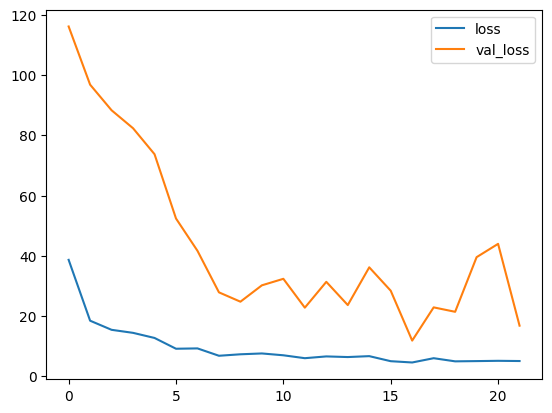

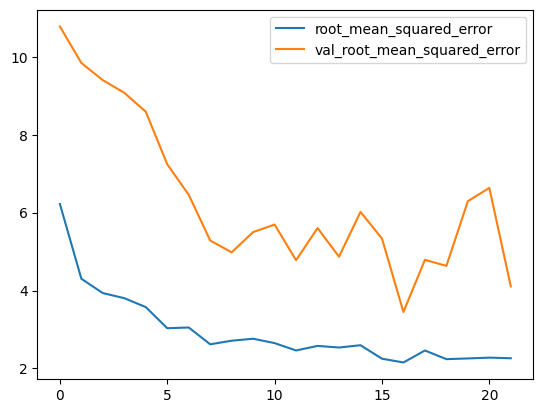

In [16]:
df = pd.DataFrame(history.history)
df.loc[:, ['loss', 'val_loss']].plot()
df.loc[:, ['root_mean_squared_error', 'val_root_mean_squared_error']].plot()

In [17]:
results = model.evaluate(test_ds)
y_true = []
y_pred = []



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 68.3215 - root_mean_squared_error: 8.2657


c:\Users\amany\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


In [19]:
rmse = np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))
r2 = 1 - (np.sum((np.array(y_true) - np.array(y_pred)) ** 2) / np.sum((np.array(y_true) - np.mean(y_true)) ** 2))

print("Test RMSE:", rmse)
print("Test R²:", r2)



Test RMSE: 8.265682
Test R²: 0.7159698605537415


In [ ]:

model.save('model.keras')